# GARCH Volatility Modeling

### Using past returns data to predict 7-day volatility for an asset

*By Jayden Reuben*

##### Overview of GARCH

Generalized Autoregressive Conditional Heteroskedasticity (GARCH) models estimate today's (time zero) volatility of an asset based on a information from a historical period. The information directly utilized in the prediction of volatility is as follows:
* Squared residuals ($ \epsilon_i = r_i - \bar{r} $), which is the actual return in time t, less the mean return
* Conditional variance for each observation
* The long-run variance (overall sample variance)
* Some parameters on the first and second terms described above ($\alpha$, $\beta$, $\omega$)

The simplest GARCH model is GARCH(1,1), which looks at one lag component of each of these variables. The model specification is as follows:

$\sigma^2_t = \phi V_L + \alpha \epsilon^2_{t-1} + \beta \sigma^2_{t-1}$

where $V_L = \frac{\omega}{1-\alpha-\beta}$ and $\omega = \phi V_L$

We can respecify the model as follows:
$\sigma^2_t = \omega + \alpha \epsilon^2_{t-1} + \beta \sigma^2_{t-1}$

##### Fund Analysis

In another post on my website, I've recently investigated the performance of ESG funds vs the VICE ETF (sin tiscxs) in a preliminary analysis. I continue this theme by modeling and predicting the volatility of an ESG fund.

I apply a GARCH(p,q) model on the returns and volatility of the TIAA-CREF Social Choice Equity Fund (TISCX). The entire data process is as follows:
1. Collect fund data via yfinance (a library which interfaces with Yahoo Finance API to query and collect price data)
2. Apply Pandas techniques to process/cleanse the data (icluding calculating log returns)
3. Visualize PACF to ascertain potential appropriate GARCH lags
4. Create training and testing datasets
5. Fitting a GARCH model and confirming the significance of the GARCH lags (alpha, beta)
6. Model GARCH and compare historical (actual) volatility and predicted volatility (visualization)
7. Volatility forecast

#### Data Collection & Processing

In [1]:
# Importing relevant libraries to utilize in the collection and wrangling of data. Additionally, other libraries are imported in order to perform statistical analyses and test models. 
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model
from random import gauss
from datetime import datetime, timedelta

In [2]:
# Historical data retrieval (5 years)
tiscx = yf.Ticker('TISCX')
tiscx = tiscx.history(interval="1d", start="2017-01-14", end="2022-01-15")
tiscx

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2017-01-13,12.642455,12.642455,12.642455,12.642455,0,0.0,0
2017-01-17,12.597250,12.597250,12.597250,12.597250,0,0.0,0
2017-01-18,12.627386,12.627386,12.627386,12.627386,0,0.0,0
2017-01-19,12.582181,12.582181,12.582181,12.582181,0,0.0,0
2017-01-20,12.627386,12.627386,12.627386,12.627386,0,0.0,0
...,...,...,...,...,...,...,...
2022-01-07,27.680000,27.680000,27.680000,27.680000,0,0.0,0
2022-01-10,27.639999,27.639999,27.639999,27.639999,0,0.0,0
2022-01-11,27.879999,27.879999,27.879999,27.879999,0,0.0,0


In [3]:
# Dropping unneeded columns - retaining only 'Close' data.
tiscx = tiscx.drop(['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits'],axis=1)
tiscx

,Close
Date,
2017-01-13,12.642455
2017-01-17,12.597250
2017-01-18,12.627386
2017-01-19,12.582181
2017-01-20,12.627386
...,...
2022-01-07,27.680000
2022-01-10,27.639999
2022-01-11,27.879999


In [4]:
# Writing a CSV file with close price data for analysis on other platforms (such as EViews, SAS, R) - separate to this analysis, as Python is only used. 
tiscx.to_csv('tiscx_px_hist.csv')

##### Computing Returns (Arithmetic and Logarithmic)

In [5]:
# Computing arithmetic returns and removing NaN values
ret = tiscx['Close'].pct_change().dropna()
ret = pd.DataFrame(ret, columns=['Close'])
ret

,Close
Date,
2017-01-17,-0.003576
2017-01-18,0.002392
2017-01-19,-0.003580
2017-01-20,0.003593
2017-01-23,-0.001790
...,...
2022-01-07,-0.007174
2022-01-10,-0.001445
2022-01-11,0.008683


In [6]:
# Computing logarithmic returns 
log_ret = np.log(tiscx.Close) - np.log(tiscx.Close.shift(1))
log_ret = pd.DataFrame(ret,columns=['Close']).dropna()
log_ret

,Close
Date,
2017-01-17,-0.003576
2017-01-18,0.002392
2017-01-19,-0.003580
2017-01-20,0.003593
2017-01-23,-0.001790
...,...
2022-01-07,-0.007174
2022-01-10,-0.001445
2022-01-11,0.008683


In [7]:
# Daily returns and variance calculations (logarithmic)
mean = np.average(log_ret['Close'])
var = np.std(log_ret['Close'])**2

#Daily 
print('Daily returns: '+str(round(mean*100,5))+'%')
print('Daily volatility: '+str(round(np.sqrt(var),5)))

Daily returns: 0.06947%
Daily volatility: 0.01231


<AxesSubplot:xlabel='Date'>

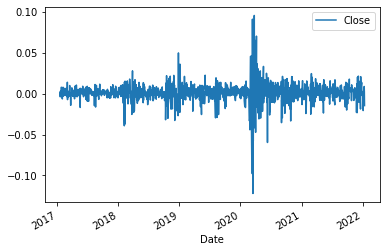

In [8]:
#Plot of TISCX log returns based on close prices
log_ret.plot()

**Comments on Returns over Time**
* Periods of increased volatility in returns are apparent, specifically around early-to-mid 2020
* Prior spikes around early 2019 and late 2019 (lesser extent than 2020)
* Persistence in volatility throughout COVID (Feb 2020 onward) - possibly?
    - Returns seem to swing more post-March 2020

#### Plotting ACF and PACF

Purpose - to visualize significant lags lengths within our returns data. From here, we make a judgement call as to the GARCH orders to test within our model.

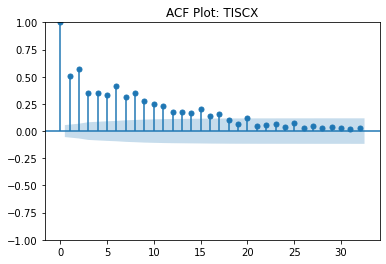

In [9]:
# Plotting autocorrelation function
plot_acf(log_ret['Close']**2)
plt.title('ACF Plot: TISCX')
plt.show()

**Comments on Autocorrelation**:
* Lag with orders of up to t-15 appear to be significant
* Not the full picture - let'visualize PACF

C:\Users\jayde\anaconda3\envs\myenv2\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


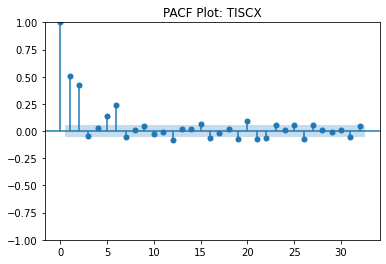

In [10]:
# Plotting partial autocorrelation function
plot_pacf(log_ret['Close']**2)
plt.title('PACF Plot: TISCX')
plt.show()

**Comments on PACF**:
* Two lags appear to be significant, with a sharp drop in significance after lag 2.
* Lags 5 and 6 may also be significant
* However - decision here is to stick with GARCH(1,1) for simplicity and also the two first orders showing strong significance (visually)

#### Training our Model
This section is concerned with segmenting 1 trading year's worth of returns (most recent) and using this data to train our model.

In [11]:
# Set training dataset equal to returns dataset (past 252 days) 
test_size = 252
train = log_ret[-test_size:]

In [12]:
# GARCH(1,1) model
model = arch_model(train, p=1,q=1)

In [13]:
# Fitting the GARCH(1,1) model
model_fit = model.fit()

C:\Users\jayde\anaconda3\envs\myenv2\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 7.51e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 80106.6228732044
Iteration:      2,   Func. Count:     18,   Neg. LLF: -236.16602833630523
Iteration:      3,   Func. Count:     27,   Neg. LLF: 68706.13544126686
Iteration:      4,   Func. Count:     37,   Neg. LLF: 100353.25902220015
Iteration:      5,   Func. Count:     49,   Neg. LLF: 3279.126480890212
Iteration:      6,   Func. Count:     60,   Neg. LLF: 1029.596692590921
Iteration:      7,   Func. Count:     70,   Neg. LLF: 84422.27223495538
Iteration:      8,   Func. Count:     82,   Neg. LLF: -258.9100460986791
Iteration:      9,   Func. Count:     91,   Neg. LLF: 1356053.3627323147
Iteration:     10,   Func. Count:    103,   Neg. LLF: -280.22582075495393
Iteration:     11,   Func. Count:    111,   Neg. LLF: -849.3419507794873
Optimization terminated successfully    (Exit mode 0)
            Current function value: -849.3419507758707
            Iterations: 15
            Function evaluations: 111
            Gradient evalua

In [14]:
# Summary statistics from the GARCH Model estimation
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                849.342
Distribution:                  Normal   AIC:                          -1690.68
Method:            Maximum Likelihood   BIC:                          -1676.57
                                        No. Observations:                  252
Date:                Mon, Jan 24 2022   Df Residuals:                      251
Time:                        21:43:30   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         7.3539e-04  4.710e-04      1.562      0.118 [-1.877e-04,1.658e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.2519e-05  4.263e-12  5.283e+06      0.000 [2.252e-05,2.252e-05]
alpha[1]       0.2004  7.403e-02      2.707  6.798e-03   [5.527e-02,  0.345]
beta[1]        0.4998  8.074e-02      6.190  6.013e-10     [  0.342,  0.658]
============================================================================

Covariance estimator: robust
"""

**Comments on TISCX GARCH Output**:
* $\alpha + \beta = 0.7002 < 1$
    - This shows that GARCH(1,1) is appropriate
* All GARCH parameters are significant (1% level)
* GARCH(1,1) is therefore appropriate in the prediction of volatility

---

#### Rolling Forecast
Building a GARCH model for each of the past 252 days. I build a GARCH(1,1) model into each of those forecasting periods and predict the next day (effectively building 252 GARCH models, iteratively).

In [15]:
rolling_pred = []
test_size = 252

for i in range(test_size):
    train = log_ret['Close'][:-(test_size-i)]
    model = arch_model(train,p=1,q=1)
    model_fit = model.fit(disp="off")
    pred = model_fit.forecast(horizon=1)
    rolling_pred.append(np.sqrt(pred.variance.values[-1,:][0]))

C:\Users\jayde\anaconda3\envs\myenv2\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001708. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
C:\Users\jayde\anaconda3\envs\myenv2\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
C:\Users\jayde\anaconda3\envs\myenv2\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, whi

In [16]:
# Set rolling prediction to past 252 trading days
rolling_pred = pd.Series(rolling_pred, index=log_ret.index[-252:])

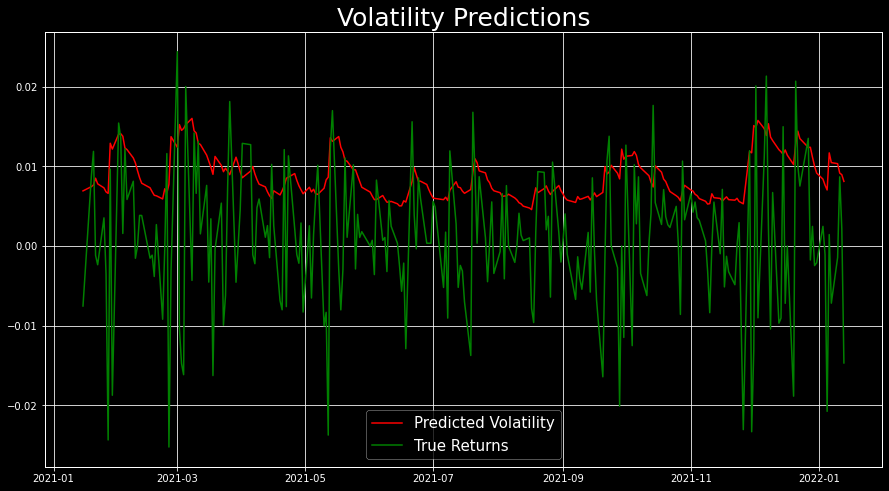

In [31]:
# Plotting volatility predictions against actual returns
plt.figure(figsize=(15,8))
plt.style.use('dark_background')
preds, = plt.plot(rolling_pred, color='red')
true, = plt.plot(log_ret['Close'][-252:], color='green')
plt.title('Volatility Predictions', fontsize=25)
plt.legend(['Predicted Volatility', 'True Returns'], fontsize=15)

**Comments on chart**:
* Predicted volatility increases and persists with sharp changes in true returns
* This is an indication that GARCH(1,1) might a good model
    - Remember that the predicted volatility is forecasted 1 day in advance of each actual observed returns 

#### Volatility Forecast (7-days)

In [18]:
# Using the past 252 days' data to train the GARCH(1,1) ***PREDICTION*** model
train = log_ret['Close'][-252:]
model = arch_model(train, p=1, q=1)
model_fit = model.fit(disp="off")

C:\Users\jayde\anaconda3\envs\myenv2\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 7.51e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [19]:
# Using the trained model to forecast GARCH(1,1) over the next 7 days
pred = model_fit.forecast(horizon=7)
future_dates =  [log_ret.index[-1] + timedelta(days=i) for i in range(1,8)]
pred = pd.Series(np.sqrt(pred.variance.values[-1,:]), index=future_dates)

C:\Users\jayde\anaconda3\envs\myenv2\lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


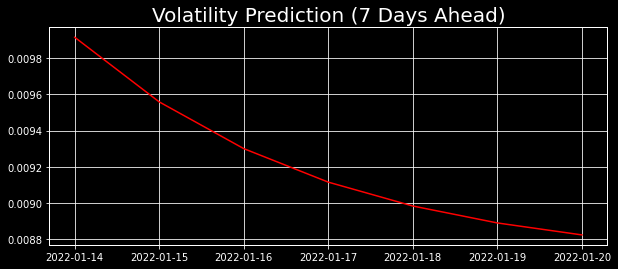

In [37]:
# Plotting projected volatilities over the next 7 days
plt.figure(figsize=(10,4))
plt.style.use('dark_background')
plt.plot(pred, color='red')
plt.title('Volatility Prediction (7 Days Ahead)', fontsize=20)
plt.savefig('vol_pred.png')

**Comments on GARCH short-term estimation**:
* Observe a fall in volatility in the next 7 days from 0.98% to approx 0.865%

The volatility predictions can be used to make decisions on stock/asset holdings. For instance, you might decide to hold TISCX in the coming week based on volatility falling. 

An institutional active fund manager facing a volatility constraint might decide that on rebalancing, based on the predicted falling volatility in the next 7 days, the next trade COULD include buying more of TISCX.